In [1]:
import ReservoirComputer_3 as ReCom
import numpy as np
import scipy.sparse as sp
import ReservoirPlot as resplt
import ReservoirAnalysis as resan
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import ipywidgets as widgets

In [11]:
def lorenz(u, *args):
    x, y, z = u[0], u[1], u[2]
    beta, rho, sigma = alpha[0], alpha[1], alpha[2]
    
    return np.asarray([sigma*(y - x), x*(rho - z) - y, x*y - beta*z])


def evolve(RC, ics, t_points):
    ics = ics.copy()
    ics.append(RC.r_T)
    traj = np.zeros((len(ics), len(t_points), RC.d))
    
    for i in range(len(ics)):
        r0 = ics[i]
        PR_traj = integrate.odeint(RC.f_PR, r0, t_points)
        prediction = np.asarray([RC.W_out.dot(RC.q(p)) for p in PR_traj])
        traj[i,:,:] = prediction
    
    return traj 


def plot_traj(ax, traj, t_start=0, t_end=40000, xlim=300, ylim=300, zlim=300):
    t_start = int(t_start)
    t_end = int(t_end)
    for i in range(len(traj)):
        u = traj[i]
        ax.plot(u[t_start:t_end, 0], u[t_start:t_end, 1], u[t_start:t_end, 2], 'r-',
                markersize=2.0, alpha=1.0,)
        
    for i in range(len(traj)):
        u = traj[i]
        ax.plot(u[t_end-1, 0], u[t_end-1, 1], u[t_end-1, 2], "ko",
                    markersize=3.0, alpha=1.0)
    
    ax.set_xlim3d(-xlim, xlim)
    ax.set_ylim3d(-ylim, ylim)
    ax.set_zlim3d(0,zlim)
    return ax
    
    
def anti_heb(RC, train_data, t_points_training, t_listen, training_traj, eta, E, size_E=9999):
    x = training_traj
    X = np.zeros((RC.N,RC.N))
    M = RC.M.copy()

    for e in range(E):
        for t in range(1, size_E):
            for i in range(RC.N):
                X[i,:] = x[t+1,i] * x[t,:]
            M = M - eta*X
    
    M = sp.csr_matrix(M)
    RC_heb = ReCom.ESN(N=RC.N, p=RC.p, d=RC.d, rho=RC.rho, sigma=RC.sigma, gamma=RC.gamma, beta=RC.beta)
    RC_heb.M = M
    RC_heb.W_in = RC.W_in.copy()
    training_traj_heb = RC_heb.train(train_data, t_points_training, t_listen)
    return RC_heb


def anti_hebN(RC, train_data, t_points_training, t_listen, training_traj, eta, E, size_E=9999):
    x = training_traj
    X = np.zeros((RC.N,RC.N))
    M = RC.M.copy()

    for e in range(E):
        for t in range(1, size_E):
            M = -(M + eta*np.dot(x[t+1][:,None], x[t][None,:]))
            A = np.diag([1/(np.linalg.norm(M[i,:])) for i in range(RC.N)])
            M = np.matmul(A, M)
            
    M = sp.csr_matrix(M)
    RC_heb = ReCom.ESN(N=RC.N, p=RC.p, d=RC.d, rho=RC.rho, sigma=RC.sigma, gamma=RC.gamma, beta=RC.beta)
    RC_heb.M = M
    RC_heb.W_in = RC.W_in.copy()
    training_traj_heb = RC_heb.train(train_data, t_points_training, t_listen)
    return RC_heb


def anti_heb2(RC, train_data, t_points_training, t_listen, training_traj, eta, E, size_E=9999):
    x = training_traj
    X = np.zeros((RC.N,RC.N))
    M = RC.M.copy()

    for e in range(E):
        for t in range(1, size_E):
            for i in range(RC.N):
                X[i,:] = x[t+1,i] * x[t,:]
            M = -(M + eta*X)
        M = sp.csr_matrix(M)    
        RC_heb = ReCom.ESN(N=RC.N, p=RC.p, d=RC.d, rho=RC.rho, sigma=RC.sigma, gamma=RC.gamma, beta=RC.beta)
        RC_heb.M = M
        RC_heb.W_in = RC.W_in.copy()
        x = RC_heb.train(train_data, t_points_training, t_listen)

    return RC_heb


def simLR(RC, train_data, t_points, t_listen, ics, eta_list, E):
    training_traj = RC.train(train_data, t_points, t_listen)
    predictions = np.zeros((eta_list.size ,E + 1 ,len(ics) + 1, t_points.size, RC.d))
    
    for i in range(eta_list.size):
        for j in range(1, E+1):
            RC_heb = anti_heb(RC, train_data, t_points, t_listen, training_traj, eta=eta_list[i], E=j)
            pert_traj = evolve(RC_heb, ics, t_points)
            predictions[i, j,:,:,:] = pert_traj
            print(eta_list[i], j)
    
    return predictions

In [12]:
T_train = 100
T_predict = 150
dt = 0.01
alpha = (8.0/3.0, 28.0, 10.0)
x0 = np.asarray([1.0, 1.0, 1.0])
t_points_training = np.linspace(0, T_train, int(T_train/dt))
t_points_prediction = np.linspace(0, T_predict, int(T_predict/dt))
train_data = integrate.odeint(lorenz, x0, t_points_training, args=alpha)
val_data = integrate.odeint(lorenz, train_data[-1], t_points_prediction, args=alpha)

In [13]:
RC = ReCom.ESN(N=100, p=0.01, d=3, rho=0.3, sigma=0.6, gamma=10.0, beta=1e-6)

In [14]:
%%time 
training_traj = RC.train(train_data, t_points_training, t_listen=5000)
prediction = RC.predict(t_points_prediction)

Wall time: 5.35 s


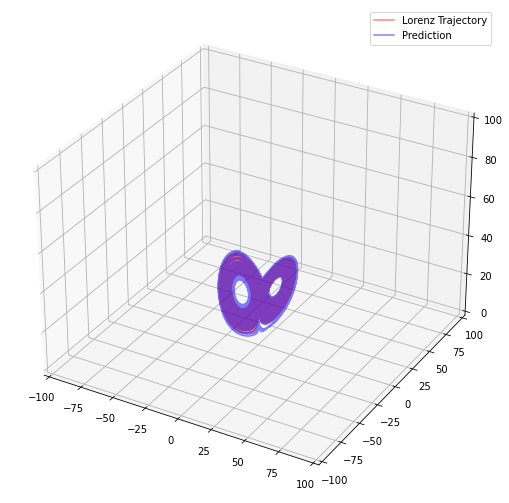

In [15]:
%matplotlib inline
fig = plt.figure(figsize=(15,9))
ax1 = fig.add_subplot(111, projection='3d')
ax1.plot(val_data[:-1,0], val_data[:-1,1], val_data[:-1,2], 'r-', markersize=1.0, alpha=0.5, label='Lorenz Trajectory')
ax1.plot(prediction[:-1,0], prediction[:-1,1], prediction[:-1,2], 'b-', markersize=1.0, alpha=0.5, label='Prediction')

xlim, ylim, zlim = 100, 100, 100
ax1.set_xlim(-xlim, xlim)
ax1.set_ylim(-ylim, ylim)
ax1.set_zlim(0, zlim)
ax1.legend()

In [18]:
%%time
eta_list = [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
predictions = np.zeros((11, 21, 15001, 3))
T = 150
dt = 0.01
n = int(round(T/dt))
t_points = np.linspace(0, T, n+1)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))
predictions[0] = evolve(RC, ics, t_points)

for i in range(1,20):
    RC_heb = anti_hebN(RC, train_data, t_points_training, 5000, training_traj, eta=eta_list[i], E=1)
    pert_traj = evolve(RC_heb, ics, t_points)
    predictions[i,:,:,:] = pert_traj
    print(i)

1
2
3
4
5
6
7
8
9
10


IndexError: list index out of range

In [ ]:
#16:50

In [ ]:
%store predictions

In [10]:
@widgets.interact(i=(0, 20, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, t_start=0, t_end=15000, xlim=50, ylim=50, zlim=50):
    prediction_heb = predictions[i]
    fig = plt.figure(figsize=(15,9))  
    plot_traj(predictions[i], t_start, t_end, xlim, ylim, zlim)

    xlim, ylim, zlim = 20, 20, 40
    ax1.set_xlim(-xlim, xlim)
    ax1.set_ylim(-ylim, ylim)
    ax1.set_zlim(0, zlim)
    ax1.legend()
    
    print("Eta = " + str(eta_list[i]))

interactive(children=(IntSlider(value=0, description='i', max=20), IntSlider(value=0, description='t_start', m…

In [ ]:
%%time
eta_list = np.arange(0, 2, 0.1)
predictions2 = np.zeros((21 ,5 ,21, 15001, 3))
T = 150
dt = 0.01
n = int(round(T/dt))
t_points = np.linspace(0, T, n+1)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))

for i in range(20):
    for j in range(1, 5):
        RC_heb = anti_heb2(RC, train_data, t_points_training, 5000, training_traj, eta=eta_list[i], E=j)
        pert_traj = evolve(RC_heb, ics, t_points)
        predictions2[i, j,:,:,:] = pert_traj

In [ ]:
%store predictions2

In [1]:
%store -r predictions2

In [8]:
eta_list = np.arange(0, 2, 0.1)

In [9]:
@widgets.interact(i=(0, 10, 1), j=(1, 4, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=1, t_start=0, t_end=15000, xlim=200, ylim=200, zlim=200):
    fig = plt.figure(figsize=(15,9))  
    plot_traj(predictions2[i,j], t_start, t_end, xlim, ylim, zlim)
    print("Eta = " + str(eta_list[i]))

interactive(children=(IntSlider(value=0, description='i', max=10), IntSlider(value=1, description='j', max=4, …

In [ ]:
%%time
eta_list = np.arange(0, 2, 0.1)
predictions3 = np.zeros((21 ,5 ,21, 15001, 3))
T = 150
dt = 0.01
n = int(round(T/dt))
t_points = np.linspace(0, T, n+1)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))

for i in range(20):
    for j in range(1, 5):
        RC_heb = anti_heb(RC, train_data, t_points_training, 5000, training_traj, eta=eta_list[i], E=j)
        pert_traj = evolve(RC_heb, ics, t_points)
        predictions3[i, j,:,:,:] = pert_traj

In [ ]:
%store predictions3

In [2]:
%store -r predictions3

In [10]:
eta_list = np.arange(0, 2, 0.1)

In [11]:
%matplotlib inline
@widgets.interact(i=(0, 10, 1), j=(1, 4, 1), t_start=(0, 15000, 10), t_end=(0, 15000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=1, t_start=0, t_end=15000, xlim=200, ylim=200, zlim=200):
    fig = plt.figure(figsize=(15,9))  
    plot_traj(predictions3[i,j], t_start, t_end, xlim, ylim, zlim)
    
    print("Eta = " + str(eta_list[i]))

interactive(children=(IntSlider(value=0, description='i', max=10), IntSlider(value=1, description='j', max=4, …

In [10]:
%%time
E = 5
eta_space = np.arange(0, 0.3, 0.01)
ics = list(np.random.uniform(low=-1, high=1, size=(20,100)))
predictions5 = simLR(RC, train_data, t_points_training, 5000, ics, eta_space, E)

0.0 1
0.0 2
0.0 3
0.0 4
0.0 5
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.02 1
0.02 2
0.02 3
0.02 4
0.02 5
0.03 1
0.03 2
0.03 3
0.03 4
0.03 5
0.04 1
0.04 2
0.04 3
0.04 4
0.04 5
0.05 1
0.05 2
0.05 3
0.05 4
0.05 5
0.06 1
0.06 2
0.06 3
0.06 4
0.06 5
0.07 1
0.07 2
0.07 3
0.07 4
0.07 5
0.08 1
0.08 2
0.08 3
0.08 4
0.08 5
0.09 1
0.09 2
0.09 3
0.09 4
0.09 5
0.1 1
0.1 2


KeyboardInterrupt: 

In [17]:
%store predictions4

Stored 'predictions4' (ndarray)


In [3]:
%store -r predictions4

In [4]:
eta_space = np.arange(0, 0.3, 0.01)
E = 5

In [8]:
%matplotlib inline
@widgets.interact(i=(0, eta_space.size, 1), j=(1, E, 1), t_start=(0, 10000, 10), t_end=(0, 10000, 10),
                  xlim=(0,4000,10), ylim=(0,4000,10), zlim=(0, 4000, 10))
def update(i=0, j=1, t_start=3000, t_end=15000, xlim=80, ylim=80, zlim=80):
    fig = plt.figure(figsize=(15,9)) 
    ax = fig.gca(projection="3d")
    plot_traj(ax, predictions4[i,j], t_start, t_end, xlim, ylim, zlim)
    
    print("Eta = " + str(eta_space[i]))

interactive(children=(IntSlider(value=0, description='i', max=30), IntSlider(value=1, description='j', max=5, …

In [46]:
t_start = 6000
t_end = 10000
xlim, ylim, zlim  = 70, 70, 70

Text(0.5, 0, '$z$')

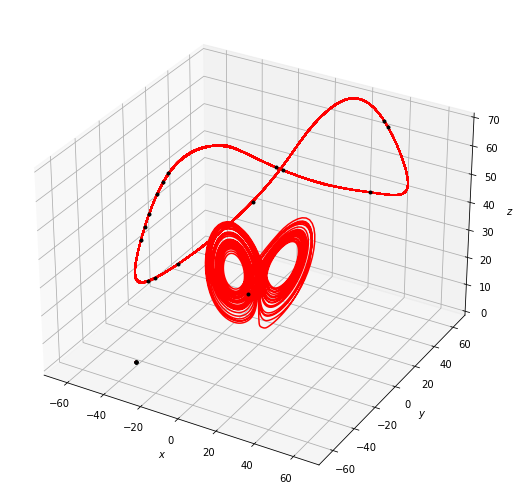

In [64]:
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1, 1, 1, projection='3d')
plot_traj(ax, predictions4[0,i+1], t_start, t_end, xlim, ylim, zlim)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")

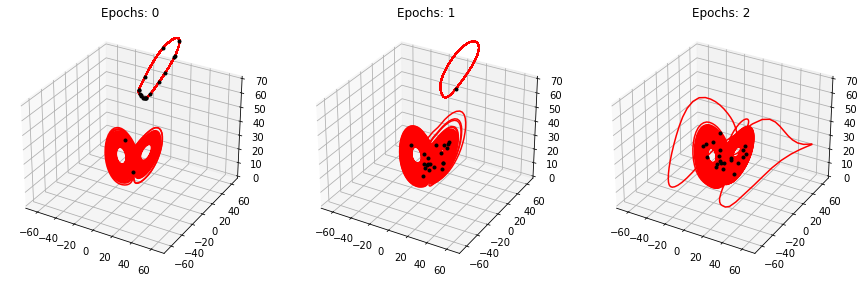

In [58]:
eta = 10
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1, 3, i, projection='3d') for i in range(1,4)]
for i in range(0, 3):
    plot_traj(ax[i], predictions4[eta,i+1], t_start, t_end, xlim, ylim, zlim)
    ax[i].set_title("Epochs: " + str(i))

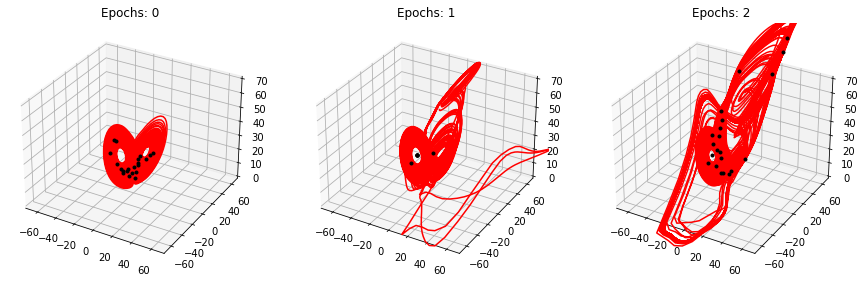

In [59]:
eta = 21
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1, 3, i, projection='3d') for i in range(1,4)]
for i in range(0, 3):
    plot_traj(ax[i], predictions4[eta,i+1], t_start, t_end, xlim, ylim, zlim)
    ax[i].set_title("Epochs: " + str(i))

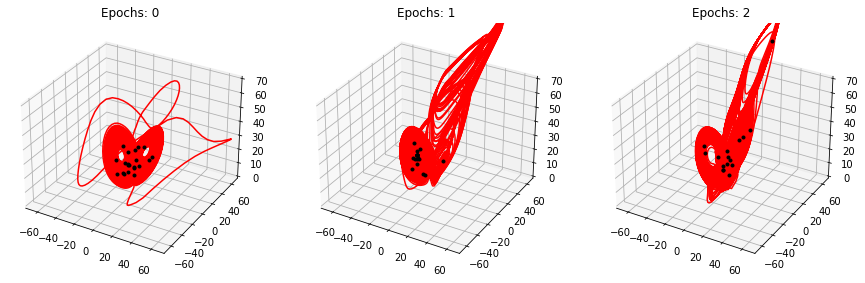

In [60]:
eta = 29
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1, 3, i, projection='3d') for i in range(1,4)]
for i in range(0, 3):
    plot_traj(ax[i], predictions4[eta,i+1], t_start, t_end, xlim, ylim, zlim)
    ax[i].set_title("Epochs: " + str(i))